# 加载基本库

In [1]:
import collections
import pandas as pd
import datetime
import time
import math
# from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
%run FeatureProcess.py
# from fastFM.datasets import make_user_item_regression
# from fastFM import als
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
import numpy as np
from sklearn import preprocessing
sklearn.__version__


'0.19.1'

# 加载数据项

In [2]:
train_df_org = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
test_df_org = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')



In [3]:
train_df_org.columns

train_df = train_df_org.copy()#.set_index("context_id")
test_df = test_df_org.copy()#.set_index("context_id")

test_df["is_trade"] = -1
train_df_prev = train_df.append(test_df)
# print len(train_df)
# print train_df[["is_trade"]]

# 预处理数据

In [4]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from datetime import datetime

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime("%Y-%m-%d")
def extract_time(x):
    d = datetime.fromtimestamp(x)
    return d.strftime("%Y-%m-%d %H:%M:%S")
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

train_df_prev['time'] = train_df_prev['context_timestamp'].apply(lambda x: extract_time(x))
train_df_prev['date'] = train_df_prev['context_timestamp'].apply(lambda x: extract_date(x))
train_df_prev['weekday'] = train_df_prev['context_timestamp'].apply(lambda x: extract_weekday(x))
train_df_prev['hour'] = train_df_prev['context_timestamp'].apply(lambda x: extract_hour(x))

m = {}
for idx, date in enumerate(sorted(train_df_prev['date'].unique())):
    m[date]=idx
print(m)

for idx, d in enumerate(sorted(train_df_prev['date'].unique())):
    train_df_prev["day"] = train_df_prev['date'].map(lambda x: m[x])

{'2018-09-18': 0, '2018-09-19': 1, '2018-09-20': 2, '2018-09-21': 3, '2018-09-22': 4, '2018-09-23': 5, '2018-09-24': 6, '2018-09-25': 7}


## 重复列特征

In [7]:
def generateColDupByDay(df, cols, gaps, dateCol='day', verbose=True):
    """
    生成新特征, 根据日期, 把特定列的去重状态排列出来

    Parameters
    ----------------
    df : data
    col : 指定列
    gap : 相隔多少天
    dateCol : 日期列, 'day', 以自然数代表天数

    offline_df = generateColDupByDay(offline_df, ['item_id', 'shop_id'], [1,2,3])
    print(offline_df.item_id_dup_g_3)
    print(offline_df.shop_id_dup_g_1)

    Returns
    ----------------
    new DataFrame with new features
    """   
    tmp = df.copy()
    for col in cols:
        for gap in gaps:
            if verbose:
                print('setting col %s_dup_g_%s' % (col, gap))
            setColDupByDay(tmp, col, gap, dateCol)
    return tmp

def setColDupByDay(df, col, gap, dateCol='day'):

    # 新特征列
    newCol = col + '_dup_gg_' + str(gap)  
    
    if newCol in df:
        return df
    
    days = len(df[dateCol].unique())

    for today in range(0, days+1):
 
        # 获取 今天以来, 今天 这两种索引
        index_alldays = np.logical_and(df[dateCol].values <= today, df[dateCol].values > (today - gap - 1))
        index_today = (df[dateCol].values == today)

        if len(df[index_today]) == 0 or len(df[index_alldays]) == 0:
            break

        # 计算今天以来col的重复状态, 并且把今天的状态拿出来set到新列
        df.loc[index_today, newCol] = df.loc[index_alldays, col].duplicated()


    # 把两种状态转换成0, 1
    le = preprocessing.LabelEncoder()
    df[newCol] = le.fit_transform(df[newCol].fillna('nodata').astype('str'))

    return df

dup_feat = ['item_id', 'item_brand_id', 'shop_id', 'user_id']
train_df_prev = generateColDupByDay(train_df_prev.reset_index(), dup_feat, list(range(1, 8)), verbose=False)

# 拆解复杂类型

In [32]:
from numpy import *
#简化list等复杂类型的结构
#item_category_list全展开
#item_property_list全展开取频率>0.05的数据
#predict_category_property会计算跟item prop和cate的余弦相似度
#具体是把两个list的数据拼成cate:-1和cate:prop两种方式拼成一个字符串再跟predict_category_property的数据计算相似度
def get_icl_map(df):
    print("get_icl_map ... ")
    dfX = df.copy()
    dfX = dfX['item_category_list'].str.split(';', expand=True)

#     s = sorted(list(dfX[0].unique()) + list(dfX[1].unique()) + list(dfX[2].unique()))
    m = {}
    for i in dfX[0].unique():
        if i == None:
            continue
        m[i] = "1"
    
    for i in dfX[1].unique():
        if i == None:
            continue
        m[i] = "2"
    
    for i in dfX[2].unique():
        if i == None:
            continue
        m[i] = "3"
    return m

def get_ipl_map(df):
    print("get_ipl_map ... ")
    df1 = df.copy()
    dfX = df1.copy()['item_property_list'].str.split(';')
    dfX = pd.DataFrame(dfX)
    
    m = collections.defaultdict(float)
    idx = 0
    for _, row in dfX.iterrows():
        for i in row[0]:
            m[i] += 1
    
    ll = len(dfX)
    for k,v in m.items():
        m[k] = v / ll
    return m

def cos_sim(a,b):
    if type(a) == type(b) == list:
        am,bm = {},{}
        for i in a:
            am[i] = 1
        for i in b:
            bm[i] = 1
        
        a = am
        b = bm
    
    up = 0.
    down = 0.
    for k in a:
        if k in b:
            up += (a[k]*b[k])
    down = math.sqrt(len(a))*math.sqrt(len(b))
    
    return up/down

def process_complex_types(dfX, icl_map, ipl_map):
    def filter_unless_cate(arr):
        ret = []
        for i in arr:
            if i in icl_map:
                ret.append(i)
        if len(ret) == 0:
            return None
        else:
            return ret
    
    def filter_unless_prop(arr):
        ret = []
        for i in arr:
            freq = ipl_map.get(i, 0.)
            if freq > 0.05:
                ret.append(i)
            else:
                ret.append(1)
        if len(ret) == 0:
            return None
        else:
            return unique_list(ret)
    
    def unique_list(arr):
        return list(set(arr))
    
    #{cate}:-1命中则为1分
    #{cate}:{prop}命中则为2分
    #后期优化权重
    def inner_product_recall_items(line):
        line = line.split("|")
        item_category_list = unique_list(line[0].split(";"))
        item_property_list = unique_list(line[1].split(";"))
        
        #删掉-1
        if "-1" in item_property_list:
            del item_property_list[item_property_list.index("-1")]
        
        
        #抽出预测的cate_list和prop_list
        line[2] = line[2].split(";")
        
        pitem_category_list_prop = {}
        pitem_category_list = []
        pitem_property_list = []
        for l in line[2]:
            l = l.split(":")
            
            if l[0] != -1:
                pitem_category_list.append(l[0])
            if len(l) >= 2 and l[1] != -1:
                l[1] = l[1].split(",")
                pitem_property_list.append(l[1])
                pitem_category_list_prop[l[0]] = l[1]
            if len(l) >= 3:
                print "FUCK?"

        
        #计算预测的cate相似度+prop相似度
        csim = cos_sim(item_category_list, pitem_category_list)
        psim = 0.
        if len(pitem_property_list) > 0:
            for i in pitem_property_list:
                psim += cos_sim(item_property_list, i)
            psim /= len(pitem_property_list)
        
        #统计category命中率
        hit_cate_rate = 0.
        hit_cate_sim = 1.
        if len(item_category_list) > 1:
            if len(item_category_list) == 2 and item_category_list[1] in pitem_category_list_prop:
                hit_cate_rate += 1
                hit_cate_sim *= (1+cos_sim(pitem_category_list_prop[item_category_list[1]], item_property_list))
            if len(item_category_list) == 3 and item_category_list[2] in pitem_category_list_prop:
                hit_cate_rate += 1
                hit_cate_sim *= (1+cos_sim(pitem_category_list_prop[item_category_list[2]], item_property_list))
            
            hit_cate_rate /= (len(item_category_list) - 1)
            
            
        
        
        predict_richness = len(set(pitem_category_list))
        item_property_richness = len(set(item_property_list))
        return [csim, psim, predict_richness, item_property_richness, hit_cate_rate, hit_cate_sim]
            
        
            
        
        
        
    print("processing predict_category_property ...")
#     dfX['predict_category_property'] = dfX['predict_category_property'].str.split(';').map(lambda x: [i.split(":")[0] for i in x]).map(filter_unless_cate)
    
    dfX['tmp'] = dfX['item_category_list']+"|"+dfX['item_property_list']+"|"+dfX['predict_category_property']
    dfX['tmp'] = dfX['tmp'].map(inner_product_recall_items)
    
    dfX['category_sim'] = dfX['tmp'].map(lambda x: x[0])
    dfX['property_sim'] = dfX['tmp'].map(lambda x: x[1])
    dfX['predict_richness'] =  dfX['tmp'].map(lambda x: x[2])
    dfX['item_property_richness'] = dfX['tmp'].map(lambda x: x[3])
    dfX['hit_cate_cnt'] = dfX['tmp'].map(lambda x: x[4])
    dfX['hit_cate_sim'] = dfX['tmp'].map(lambda x: x[5])
    dfX.drop("tmp")
    
    print("processing item_property_list ...")
    dfX['item_property_list'] = dfX['item_property_list'].str.split(';').map(filter_unless_prop)
    
    print("processing item_category_list ...")
    dfX['item_category_list'] = dfX['item_category_list'].str.split(';')
    
    print "generating item_category_1, item_category_2 ..."
#     dfX['item_category_list01'] = dfX['item_category_list'].map(lambda x:x[0] if x != None and len(x) > 0 else None)
    dfX['item_category_1'] = dfX['item_category_list'].map(lambda x:int(x[1]) if x != None and len(x) > 1 else None)
    dfX['item_category_2'] = dfX['item_category_list'].map(lambda x:int(x[2]) if x != None and len(x) > 2 else None)
    
    return dfX



# aaa = process_complex_types(train_df.copy(), get_icl_map(train_df), get_ipl_map(train_df))

train_df_prev = process_complex_types(train_df_prev, get_icl_map(train_df_prev), get_ipl_map(train_df_prev))
# train_df_prev["item_category_1"] = train_df_prev["item_category_1"].astype('int')
# train_df_prev["item_category_2"] = train_df_prev["item_category_2"].astype('int')

get_icl_map ... 
get_ipl_map ... 
processing predict_category_property ...
processing item_property_list ...
processing item_category_list ...
generating item_category_1, item_category_2 ...


## 统计一个用户重复看某个商品的次数+一个用户重复看某类商品的次数

In [6]:
class set_review_cnt:
    def __init__(self, key1, key2, cnt_k1_k2_review):
        self.key1 = key1
        self.key2 = key2
        self.tmp = collections.defaultdict(int)
        self.cnt_k1_k2_review = cnt_k1_k2_review
    def __call__(self, x):
        val1,val2 = x[self.key1], x[self.key2]
        vk = (val1, val2)
        if val2 < 0:
            return np.nan 
        if val2 == None:
            return np.nan

        cnt = self.cnt_k1_k2_review[vk]
        if cnt == 0:
            return 0
        else:
            
            k = "%s_%s" % (val1, val2)
            ret = self.tmp[k]
            self.cnt_k1_k2_review[vk] -= 1
            self.tmp[k] += 1
            return ret
        
def use_feautre_review_cnt(df, feature, new_feature):
    
    cnt_feature_review = df[["user_id", feature, "instance_id"]].groupby(["user_id", feature])['instance_id'].count().to_dict() 
    f = set_review_cnt("user_id", feature, cnt_feature_review)
    
    df = df.sort_values(by="context_timestamp")
    df[new_feature] = df[["user_id", feature]].apply(f, axis=1)
    
    return df

    

    
tmp_df = train_df_prev.copy()

features = [
    ["item_id", "item_review_cnt"],
    ["item_category_1", "cate_review_cnt"],
#     ["item_category_2", "cate2_review_cnt"],
    ["item_brand_id", "brand_review_cnt"],
    ["item_price_level", "price_review_cnt"],
    ["item_sales_level", "sales_review_cnt"],
    ["item_pv_level", "pv_review_cnt"],
    ["item_collected_level", "collected_review_cnt"],
    ["item_city_id", "city_review_cnt"]
]

show_features = []
for f in features:
    print "caling %s into %s ..." % (f[0], f[1])
    tmp_df = use_feautre_review_cnt(tmp_df, f[0], f[1])
    show_features.append(f[1])
    

caling item_id into item_review_cnt ...
caling item_category_1 into cate_review_cnt ...
caling item_brand_id into brand_review_cnt ...
caling item_price_level into price_review_cnt ...
caling item_sales_level into sales_review_cnt ...
caling item_pv_level into pv_review_cnt ...
caling item_collected_level into collected_review_cnt ...
caling item_city_id into city_review_cnt ...


In [7]:
train_df_prev = tmp_df
# for f in show_features:
#     print "\n", f
#     for v in train_df_prev[f].unique():
#         print v, len(train_df_prev[train_df_prev[f] == v])
#     print '-' * 30
#     print ""
cnt_feautre_review = show_features
train_df_prev[show_features].describe()


,item_review_cnt,cate_review_cnt,brand_review_cnt,price_review_cnt,sales_review_cnt,pv_review_cnt,collected_review_cnt,city_review_cnt
count,496509.000000,496509.000000,496018.000000,496509.000000,495561.000000,496509.000000,496509.000000,496226.000000
mean,0.086780,1.109394,0.198612,0.831550,0.319499,0.367798,0.318697,0.598862
std,0.365856,2.142329,0.647292,1.697039,0.800378,0.878178,0.796520,1.459132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,15.000000,52.000000,20.000000,49.000000,27.000000,26.000000,24.000000,52.000000


# 转化属性增加trade_rate + trade_pv（按前一天）

In [8]:
# 统计信息附加

def calcTVTransform(df, key, key_y, filter_src, filter_dst, smoothing = 5, mean0=None):
    if mean0 is None:
        #计算目标的平均值做平缓用
        mean0 = df.ix[filter_src, key_y].mean()
        print("mean0:", mean0)
    
    #取出key的所有值
    df['_key1'] = df[key].astype('category').values.codes
    
    
    #取出用于计算的源（后面聚合掉就没有顺序可言了）
    df_key1_y = df.ix[filter_src, ['_key1', key_y]]
    
    #根据key的取值去聚合key_y的总数和总和，用户计算rate和count
    grp1 = df_key1_y.groupby(['_key1'])
    sum1 = grp1[key_y].aggregate(np.sum)
    cnt1 = grp1[key_y].aggregate(np.size)
    
    vn_sum = 'sum_' + key
    vn_cnt = 'cnt_' + key
    
    #取出dst（带序列）的所有key
    v_codes = df.ix[filter_dst, '_key1']
    
    #得到_sum,_cnt，按dst的序列
    _sum = sum1[v_codes].values
    _cnt = cnt1[v_codes].values
    _cnt[np.isnan(_sum)] = 0    
    _sum[np.isnan(_sum)] = 0
    
    r = {}
    r['exp'] = (_sum + smoothing * mean0)/(_cnt + smoothing)
    r['cnt'] = _cnt
    return r


In [9]:
#计算前一天的交易率set到下一天，第0天用回自己
# tmp = train_df.copy()
tmp = train_df_prev

add_count = False
# window = 2

exp = "exp_d_"
cnt = "cnt_d_"


exp_numerical = {}
cnt_numerical = {}

In [10]:

k = "day"
exp_k = "exp_d_day"
for day in xrange(0,7):
    cal_day = day
    set_day = day

    print("cal %s trade_rate cnt %s set to %s" % (k,cal_day, set_day))

    #start_d - day(不含day)用于计算，结果赋值到day上
    days1 = (tmp.day.values == cal_day)
    days2 = (tmp.day.values == set_day)
    ret = calcTVTransform(tmp, k, 'is_trade', days1, days2, 0)

    tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]

    exp_numerical[exp_k]=1

tmp.loc[tmp.day.values == 7, exp_k] = 0.0169

tmp[[exp_k, "day"]]

cal day trade_rate cnt 0 set to 0
('mean0:', 0.020020953646445547)


/Users/yuhua/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


cal day trade_rate cnt 1 set to 1
('mean0:', 0.019681098532376536)
cal day trade_rate cnt 2 set to 2
('mean0:', 0.01936040475528975)
cal day trade_rate cnt 3 set to 3
('mean0:', 0.019312068989733002)
cal day trade_rate cnt 4 set to 4
('mean0:', 0.018867648350361546)
cal day trade_rate cnt 5 set to 5
('mean0:', 0.017276071305058635)
cal day trade_rate cnt 6 set to 6
('mean0:', 0.016910189651869526)


,exp_d_day,day
3844,0.020021,0
24046,0.020021,0
59329,0.020021,0
70767,0.020021,0
76650,0.020021,0
27196,0.020021,0
57458,0.020021,0
59196,0.020021,0
24479,0.020021,0
23301,0.020021,0


In [11]:


#此处应该处理按天为梯度的数据
for k in ['item_price_level',
'item_sales_level',
'item_collected_level',
'item_pv_level',
'user_gender_id',
'user_age_level',
'user_occupation_id',
'user_star_level',
'context_page_id',
'shop_review_num_level',
'shop_star_level',
         

"item_brand_id",
"item_city_id",
"item_id",
"shop_id",
# "user_id",
          
"item_brand_id",
"item_city_id"
         ]:
    exp_k = exp+k
    cnt_k = cnt+k
    for day in xrange(0,8):
#         start_d = max(day - window, 0)
#         end_d = max(day - 1,0)
        cal_day = max(day - 1, 0)
        set_day = day

        print("cal %s trade_rate cnt %s set to %s" % (k,cal_day, set_day))
        
        #start_d - day(不含day)用于计算，结果赋值到day上
        days1 = (tmp.day.values == cal_day)
        days2 = (tmp.day.values == set_day)
        ret = calcTVTransform(tmp, k, 'is_trade', days1, days2)
            
        tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]
        
        exp_numerical[exp_k]=1
        if add_count:
            cnt_numerical[cnt_k]=1
            tmp.loc[tmp.day.values == day, cnt_k] = ret["cnt"]


cal item_price_level trade_rate cnt 0 set to 0
('mean0:', 0.020020953646445547)
cal item_price_level trade_rate cnt 0 set to 1
('mean0:', 0.020020953646445547)
cal item_price_level trade_rate cnt 1 set to 2
('mean0:', 0.019681098532376536)
cal item_price_level trade_rate cnt 2 set to 3
('mean0:', 0.01936040475528975)
cal item_price_level trade_rate cnt 3 set to 4
('mean0:', 0.019312068989733002)


/Users/yuhua/anaconda2/lib/python2.7/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


cal item_price_level trade_rate cnt 4 set to 5
('mean0:', 0.018867648350361546)
cal item_price_level trade_rate cnt 5 set to 6
('mean0:', 0.017276071305058635)
cal item_price_level trade_rate cnt 6 set to 7
('mean0:', 0.016910189651869526)
cal item_sales_level trade_rate cnt 0 set to 0
('mean0:', 0.020020953646445547)
cal item_sales_level trade_rate cnt 0 set to 1
('mean0:', 0.020020953646445547)
cal item_sales_level trade_rate cnt 1 set to 2
('mean0:', 0.019681098532376536)
cal item_sales_level trade_rate cnt 2 set to 3
('mean0:', 0.01936040475528975)
cal item_sales_level trade_rate cnt 3 set to 4
('mean0:', 0.019312068989733002)
cal item_sales_level trade_rate cnt 4 set to 5
('mean0:', 0.018867648350361546)
cal item_sales_level trade_rate cnt 5 set to 6
('mean0:', 0.017276071305058635)
cal item_sales_level trade_rate cnt 6 set to 7
('mean0:', 0.016910189651869526)
cal item_collected_level trade_rate cnt 0 set to 0
('mean0:', 0.020020953646445547)
cal item_collected_level trade_rate c

cal item_id trade_rate cnt 4 set to 5
('mean0:', 0.018867648350361546)
cal item_id trade_rate cnt 5 set to 6
('mean0:', 0.017276071305058635)
cal item_id trade_rate cnt 6 set to 7
('mean0:', 0.016910189651869526)
cal shop_id trade_rate cnt 0 set to 0
('mean0:', 0.020020953646445547)
cal shop_id trade_rate cnt 0 set to 1
('mean0:', 0.020020953646445547)
cal shop_id trade_rate cnt 1 set to 2
('mean0:', 0.019681098532376536)
cal shop_id trade_rate cnt 2 set to 3
('mean0:', 0.01936040475528975)
cal shop_id trade_rate cnt 3 set to 4
('mean0:', 0.019312068989733002)
cal shop_id trade_rate cnt 4 set to 5
('mean0:', 0.018867648350361546)
cal shop_id trade_rate cnt 5 set to 6
('mean0:', 0.017276071305058635)
cal shop_id trade_rate cnt 6 set to 7
('mean0:', 0.016910189651869526)
cal item_brand_id trade_rate cnt 0 set to 0
('mean0:', 0.020020953646445547)
cal item_brand_id trade_rate cnt 0 set to 1
('mean0:', 0.020020953646445547)
cal item_brand_id trade_rate cnt 1 set to 2
('mean0:', 0.019681098

In [12]:
exp_numerical = exp_numerical.keys()
cnt_numerical = cnt_numerical.keys()

print(exp_numerical)
print(cnt_numerical)



['exp_d_user_age_level', 'exp_d_item_pv_level', 'exp_d_shop_review_num_level', 'exp_d_item_sales_level', 'exp_d_user_occupation_id', 'exp_d_item_city_id', 'exp_d_item_brand_id', 'exp_d_user_star_level', 'exp_d_item_price_level', 'exp_d_day', 'exp_d_item_id', 'exp_d_shop_star_level', 'exp_d_item_collected_level', 'exp_d_user_gender_id', 'exp_d_context_page_id', 'exp_d_shop_id']
[]


In [17]:
print "RECOVER"
train_df = train_df_prev.copy().sort_index()

RECOVER


# 标记训练用的列

In [18]:
#标记训练数据

import copy
target="is_trade"
                          
                          
                        
categorical=[  
                'item_price_level',
                'item_sales_level',
                'item_collected_level',
                'item_pv_level',
                'user_gender_id',
                'user_age_level',
                'user_occupation_id',
                'user_star_level',
                'context_page_id',
                'shop_review_num_level',
                'shop_star_level',
                "weekday",
                "hour",
    
                'item_category_1',
                'item_category_2',
                
                "item_brand_id",
                "item_city_id",
                "item_id",
                "shop_id",
    
            ]+cnt_feautre_review

numerical=[     'shop_review_positive_rate',
                'shop_score_service',
                'shop_score_delivery',
                'shop_score_description',
#                 'predict_category_property',
                'predict_richness',
                'item_property_richness'
                   
#               ]
          ]+exp_numerical

listype = [
    'item_property_list', 
#     'item_category_list'
]

                    
            

cols_tool = filter_on_cols(target, categorical, numerical, listype)

In [19]:
train_df[cols_tool.get_raw_numerical_cols()].describe()

,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description,predict_richness,item_property_richness,exp_d_user_age_level,exp_d_item_pv_level,exp_d_shop_review_num_level,exp_d_item_sales_level,exp_d_user_occupation_id,exp_d_item_city_id,exp_d_item_brand_id,exp_d_user_star_level,exp_d_item_price_level,exp_d_day,exp_d_item_id,exp_d_shop_star_level,exp_d_item_collected_level,exp_d_user_gender_id,exp_d_context_page_id,exp_d_shop_id
count,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000
mean,0.994833,0.971131,0.970495,0.974870,4.810191,34.235279,0.019208,0.019182,0.019205,0.019192,0.019196,0.019149,0.019156,0.019191,0.019127,0.018794,0.019465,0.019197,0.019203,0.019201,0.019204,0.019042
std,0.011875,0.023607,0.023567,0.024823,1.795871,10.100147,0.003049,0.002667,0.003738,0.005930,0.001746,0.007948,0.017160,0.002817,0.008326,0.001128,0.023115,0.003774,0.003000,0.001897,0.002717,0.020898
min,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,6.000000,0.000985,0.000722,0.000925,0.000521,0.000985,0.000455,0.000229,0.000985,0.000991,0.016900,0.000287,0.000531,0.000545,0.010104,0.004171,0.000237
25%,0.992780,0.966360,0.965677,0.969282,3.000000,28.000000,0.017564,0.017939,0.017704,0.015125,0.018679,0.013794,0.006876,0.018385,0.014194,0.017276,0.004033,0.016705,0.017904,0.018869,0.018735,0.004389
50%,1.000000,0.972347,0.971579,0.978493,5.000000,33.000000,0.019105,0.019256,0.018837,0.019286,0.019032,0.016974,0.017874,0.019564,0.016366,0.019312,0.011792,0.018953,0.019162,0.019397,0.019370,0.012949
75%,1.000000,0.977822,0.976966,0.983626,6.000000,38.000000,0.020800,0.020019,0.021641,0.022024,0.019854,0.022694,0.024959,0.020864,0.023363,0.019681,0.025886,0.022550,0.020535,0.019800,0.020518,0.027273
max,1.000000,1.000000,1.000000,1.000000,14.000000,99.000000,0.027449,0.182390,0.084623,0.037044,0.022760,0.189505,0.231820,0.054228,0.109656,0.020021,0.299543,0.122234,0.035202,0.023104,0.026027,0.262301


# 平滑处理连续型数据最后对复杂类型做onehot编码

In [20]:
#数据的预处理
#double系列(例如好评率)的数据存在一个问题，没有考虑到评论量，所以乘了一个评论level，类似 好评率*评论数(分桶了) = 好评量(分桶了)
#fillempty把-1设置成-0.01，配合mov2pos使用
#mov2pos把有<0的数据都集体-min，如果一个数据是0-1，有-1出现的时候，上面设置成了-0.01，所以这列数据真实是-0.01 - 1,然后我会集体-(-0.01)
#norm用了最大值最小值norm
%run FeatureProcess.py
from sklearn import preprocessing


def layering(df, key, by_key):
    uniqv = df[by_key].unique()
    keys = []
    for v in uniqv:
        indexer = (df[by_key] == v)
        new_key = "*%sLAY*_%s" % (str(v), key)
        df.loc[indexer, new_key] = df[indexer][key]
        keys.append(new_key)
    return df, keys





featProc = FeatureProcess(target=target, categorical=categorical, numerical=numerical, listype = listype)

train_df = featProc.fillempty(train_df, -0.01)
# train_df = featProc.mov2pos(train_df)
train_df = featProc.mov2mean(train_df)
train_df = featProc.norm(train_df)
train_df[cols_tool.get_raw_numerical_cols()].describe()


,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description,predict_richness,item_property_richness,exp_d_user_age_level,exp_d_item_pv_level,exp_d_shop_review_num_level,exp_d_item_sales_level,exp_d_user_occupation_id,exp_d_item_city_id,exp_d_item_brand_id,exp_d_user_star_level,exp_d_item_price_level,exp_d_day,exp_d_item_id,exp_d_shop_star_level,exp_d_item_collected_level,exp_d_user_gender_id,exp_d_context_page_id,exp_d_shop_id
count,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000
mean,0.982014,0.865794,0.827843,0.883320,0.293092,0.303605,0.688612,0.101611,0.218402,0.511220,0.836325,0.098886,0.081723,0.341940,0.166898,0.606917,0.064086,0.153373,0.538369,0.699759,0.687828,0.071759
std,0.032251,0.043904,0.054594,0.056408,0.138144,0.108604,0.115209,0.014680,0.044658,0.162354,0.080191,0.042041,0.074096,0.052908,0.076621,0.361303,0.077242,0.031012,0.086564,0.145956,0.124316,0.079743
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.974731,0.842328,0.798142,0.856064,0.153846,0.236559,0.626489,0.094769,0.200471,0.399855,0.812573,0.070562,0.028698,0.326793,0.121504,0.120499,0.012521,0.132899,0.500887,0.674225,0.666383,0.015845
50%,1.000000,0.870375,0.832816,0.899184,0.307692,0.290323,0.684715,0.102018,0.214012,0.513787,0.828809,0.087382,0.076188,0.348955,0.141488,0.772863,0.038448,0.151369,0.537175,0.714830,0.695428,0.048508
75%,1.000000,0.896039,0.864508,0.923249,0.384615,0.344086,0.748742,0.106222,0.247507,0.588760,0.866525,0.117639,0.106783,0.373371,0.205879,0.891105,0.085545,0.180926,0.576776,0.745833,0.747943,0.103168
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 定义模型函数

In [21]:
%run ffmyh.py
        
def train_and_test_lgb(train_df, test_df, categorical_feature, res_df):
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
    model = lgb.LGBMClassifier(num_leaves=63, max_depth=7, n_estimators=80, n_jobs=5)
    model.fit(X_train, y_train, feature_name=list(X_train.columns),
            categorical_feature=categorical_feature)
    
    ft_w = pd.DataFrame(model.feature_importances_, columns=["weights"], index = list(X_train.columns))
    print ft_w
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("xgboost_res.csv",index=False,sep=' ')
        
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_xgboost(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
#     model = xgboost.XGBClassifier(reg_lambda=1.5,learning_rate=0.1,reg_alpha=0,nthread=7,n_estimators=100,max_depth=10)
#     model = xgboost.XGBClassifier(subsample=0.9,colsample_bytree=0.9,n_estimators=100,max_depth=6,nthread=5)
    model = xgboost.XGBClassifier(n_jobs=7,max_depth=5,n_estimators=91,min_child_weight=5, gamma=6.6)

#     model = xgboost.XGBClassifier(subsample=0.9,colsample_bytree=0.9,n_estimators=50,max_depth=3,nthread=1)
    model.fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(12,18))
    xgboost.plot_importance(model,ax=ax)
    plt.show()
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("xgboost_res.csv",index=False,sep=' ')
        
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_lr(train_df, test_df, res_df):    
    X_train = train_df.copy().fillna(0)
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy().fillna(0)
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
    
    model = LogisticRegression(C=1.0, n_jobs=7,tol=1e-6, max_iter=2000)
    model.fit(X_train.values, y_train)
#     for idx, val in enumerate(list(X_train.columns)):
#         print("%s=%s" %(val,list(model.coef_[0])[idx]))


    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        res_df = res_df.copy().fillna(0)
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("lr_res.csv",index=False,sep=' ')
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_randomforest(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
#     rf = RandomForestClassifier(n_estimators=32, max_depth=40, min_samples_split=100, min_samples_leaf=10,  criterion='entropy',
#                         max_features=8, verbose = 1,  bootstrap=False, n_jobs=10)
#     RandomForestClassifier(criterion='entropy',n_estimators=100,n_jobs=15)

    model = RandomForestClassifier(random_state=9,n_jobs=7, n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10,  criterion='entropy', max_features=8, verbose = 1,  bootstrap=False)
    model.fit(X_train, y_train)
    
    ft_w = pd.DataFrame(model.feature_importances_, columns=["weights"], index = list(X_train.columns))
    print ft_w.sort_values("weights", ascending=False)
#     fig, ax = plt.subplots(figsize=(12,18))
#     xgboost.plot_importance(model,ax=ax)
#     plt.show()
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("randomforest_res.csv",index=False,sep=' ')
        
        
   
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_gbdt(train_df, test_df, res_df):
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    model = GradientBoostingClassifier(n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10, max_features=4)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("gbdt_res.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls




def train_and_test_FFM(train_df, test_df, res_df):
    global cols_tool
    
    model = FFM(target=cols_tool.target, categorical=cols_tool.categorical, numerical=cols_tool.numerical, listype=cols_tool.listype,
                                        reg_param = 0.0004,
                                        k = 4,
                                        iter_max = 500,
                                        learing_rate = 0.1,
                                        threads = 7,
                                        auto_stop = False,
                                        quiet = False,
                                        no_norm = False)


    
    model.fit(train_df, test_df)
    
    train_lls = log_loss(train_df["is_trade"],model.predict_proba(train_df))
    test_lls = log_loss(test_df["is_trade"],model.predict_proba(test_df))
    
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("ffm.csv",index=False,sep=' ')
        
    
    return train_lls, test_lls


def select_best_features(df, precent=0.8):
    from sklearn.feature_selection import SelectKBest,chi2 
    df = df.copy().replace(-1, 0).fillna(0)
    
    for u in df.columns:
        df[df[u] == -1] = 0

    X_train = df.copy()
    del X_train['is_trade']
    y_train = df['is_trade']
    
    c = int(len(X_train.columns) * precent)
    skb = SelectKBest(chi2,k=c)
    skb.fit_transform(X_train,y_train)
    
    old_fea = list(X_train.columns)
    new_fea = []
    for idx, b in enumerate(list(skb.get_support())):
        if b:
            new_fea.append(old_fea[idx])
        else:
            print("Filter feature:%s" % old_fea[idx])
    return new_fea

# 开搞！

In [22]:

def dim_reduce_topn(df, dim, n, v=1):
    df2 = pd.DataFrame(df[dim].value_counts()/len(df))
    m = dict(df2.nlargest(n, dim)[dim])
    df[dim] = df[dim].map(lambda x: x if x in m else v)

    return df

def dim_reduce_rate(df, dim, rate, v=1):
    df2 = pd.DataFrame(df[dim].value_counts()/len(df))
    m = dict(df2[df2[dim] > rate][dim])
    df[dim] = df[dim].map(lambda x: x if x in m else v)
    return df

def dim_reduce_cnt(df, dim, cnt, v=1):
    df2 = pd.DataFrame(df[dim].value_counts())
    m = dict(df2[df2[dim] > cnt][dim])
    df[dim] = df[dim].map(lambda x: x if x in m else v)
    return df

def bucketizer_linear(df, key, bins, cover=False):
    nkey="*BUK*_"+key
    df[nkey] = np.nan
    idxer = df[key].values < bins[0]
    print idxer
    b = 1
    df.loc[idxer, nkey] = b
    print "x < %s : %s" % (bins[0], b)
    b += 1
    start = bins[0]
    for end in bins[1:]:
        idxer = np.logical_and(start <= df[key].values, df[key].values < end)
        df.loc[idxer, nkey] = b
        
        print "%s <= x < %s : %s" % (start, end, b)
        b+=1
        
        start = end
    
    print "%s <= x : %s" % (bins[-1], b)
    idxer = bins[-1] <= df[key].values
    df.loc[idxer, nkey] = b
    if cover:
        df[key] = df[nkey]
        df.drop(nkey)
    return df



    
# tmp_train_df["prop_len"] = tmp_train_df["item_property_list"].map(lambda x: len(x))
# tmp_train_df[["prop_len"]].describe()

5
12
7
31
[ True False False ...  True False False]
x < 1 : 1
1 <= x < 2 : 2
2 <= x < 3 : 3
3 <= x < 4 : 4
4 <= x < 5 : 5
5 <= x < 6 : 6
6 <= x < 7 : 7
7 <= x < 8 : 8
8 <= x < 9 : 9
9 <= x < 10 : 10
10 <= x < 12 : 11
12 <= x : 12
[ True  True False ...  True  True  True]
x < 1 : 1
1 <= x < 2 : 2
2 <= x < 3 : 3
3 <= x < 4 : 4
4 <= x < 5 : 5
5 <= x < 6 : 6
6 <= x : 7
[ True  True False ...  True  True False]
x < 1 : 1
1 <= x < 2 : 2
2 <= x < 3 : 3
3 <= x < 4 : 4
4 <= x < 5 : 5
5 <= x < 6 : 6
6 <= x < 7 : 7
7 <= x < 8 : 8
8 <= x < 9 : 9
9 <= x < 12 : 10
12 <= x : 11
org dataset = 496509
0    78268
3    71199
1    70931
2    68387
4    68318
5    63614
6    57421
7    18371
Name: day, dtype: int64
0    78268
3    71199
1    70931
2    68387
4    68318
5    63614
6    57421
7    18371
Name: day, dtype: int64
Using Features ...
['is_trade', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_lev

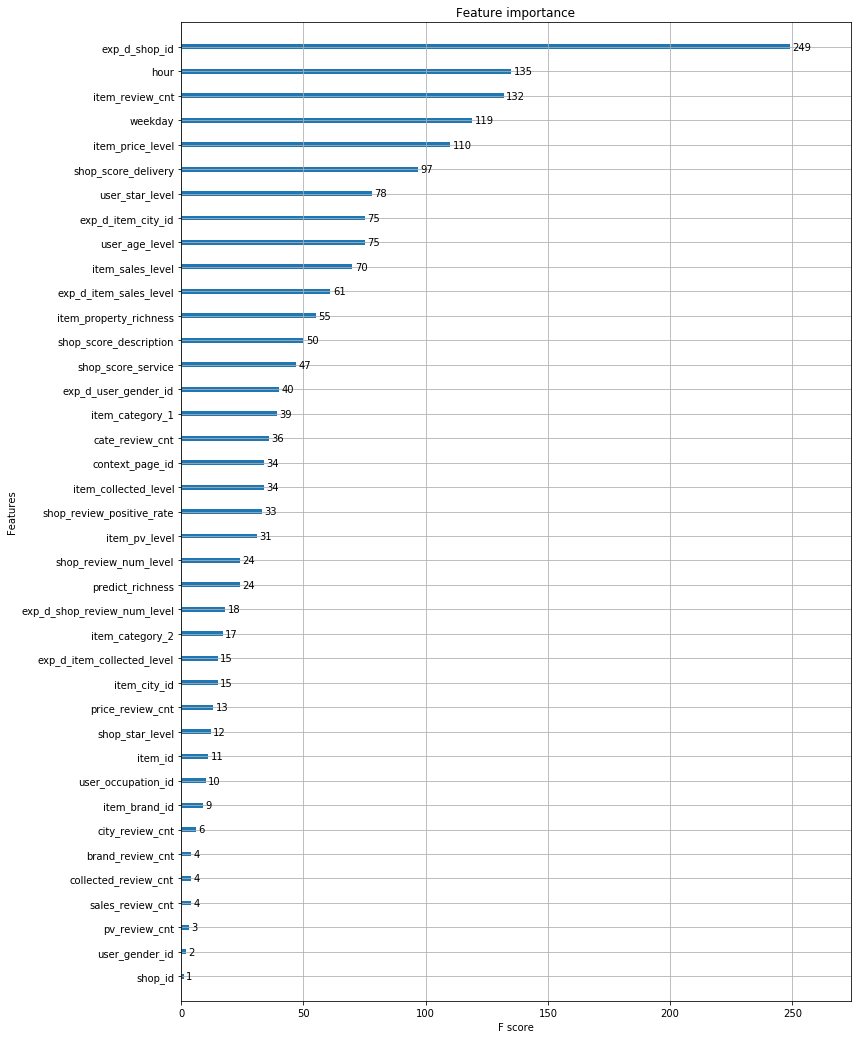

/Users/yuhua/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


XGBoost 40 dimension TrainLogLoss = 0.08612525792094296 | TestLogLoss = 0.08566119824511106


In [26]:
#这块一般不怎么需要改了，拿最后一天做验证
#注意下面验证版和测试版，测试版是我们自己玩的，验证版是扔线上的，通过注释不同的跑就行了


# %run BaseFrame.py
% run ../util/time_series_split.py

total_train_df = train_df.copy().fillna(-1)

#reduce
print len(dim_reduce_rate(total_train_df, "shop_id", 0.01)["shop_id"].unique())
print len(dim_reduce_rate(total_train_df, "item_city_id", 0.01)["item_city_id"].unique())
print len(dim_reduce_rate(total_train_df, "item_brand_id", 0.01)["item_brand_id"].unique())
print len(dim_reduce_topn(total_train_df, "item_id", 30)["item_id"].unique())


dim_reduce_topn(total_train_df, "item_review_cnt", 3, 666)
dim_reduce_topn(total_train_df, "cate_review_cnt", 8, 666)
dim_reduce_topn(total_train_df, "brand_review_cnt", 3, 666)


bucketizer_linear(total_train_df, "price_review_cnt", [1,2,3,4,5,6,7,8,9,10,12], True)
bucketizer_linear(total_train_df, "sales_review_cnt", [1,2,3,4,5,6], True)
dim_reduce_topn(total_train_df, "pv_review_cnt", 6, 666)
dim_reduce_topn(total_train_df, "collected_review_cnt", 6, 666)
bucketizer_linear(total_train_df, "city_review_cnt", [1,2,3,4,5,6,7,8,9,12], True)


cols_tool.fit(total_train_df)

categorical_one_hot_cols = cols_tool.get_onehoted_cols("categorical")
listype_one_hot_cols = cols_tool.get_onehoted_cols("listype")

index_col = "instance_id"


categorical_cols = cols_tool.get_raw_categorical_cols()
listype_cols = cols_tool.get_raw_listype_cols()
numerical_cols = cols_tool.get_raw_numerical_cols()
target_col = cols_tool.get_raw_target_col()


print("org dataset = %s" % len(total_train_df))
print(total_train_df["day"].value_counts())


print(total_train_df["day"].value_counts())

#测试版
valid_df = total_train_df.loc[total_train_df["day"]==6]
sub_train_df = total_train_df.loc[total_train_df["day"]<6]
# sub_train_df = sub_train_df.loc[sub_train_df["day"]>0]
res_df=valid_df.copy()

# #线上验证版
# valid_df = total_train_df.loc[total_train_df["day"]==6]
# res_df = total_train_df.loc[total_train_df["day"]==7]
# sub_train_df = total_train_df.loc[total_train_df["day"]<=6]

# print("res dataset = %s" % len(res_df))
# print("valid dateset = %s" % len(valid_df))
# print("train dateset = %s" % len(sub_train_df))


# on_cols = [target_col]+categorical_cols+numerical_cols
on_cols = [
    'is_trade'
, 'item_price_level'
, 'item_sales_level'
, 'item_collected_level'
, 'item_pv_level'
, 'user_gender_id'
, 'user_age_level'
, 'user_occupation_id'
, 'user_star_level'
, 'context_page_id'
, 'shop_review_num_level'
, 'shop_star_level'
, 'weekday'
, 'hour'
, 'item_category_1'
, 'item_category_2'
, 'item_brand_id'
, 'item_city_id'
, 'item_id'
, 'shop_id'
, 'item_review_cnt'
, 'cate_review_cnt'
, 'brand_review_cnt'
, 'price_review_cnt'
, 'sales_review_cnt'
, 'pv_review_cnt'
, 'collected_review_cnt'
, 'city_review_cnt'
, 'shop_review_positive_rate'
, 'shop_score_service'
, 'shop_score_delivery'
, 'shop_score_description'
, 'predict_richness'
, 'item_property_richness'
    
# , 'exp_d_user_age_level'
# , 'exp_d_item_pv_level'
, 'exp_d_shop_review_num_level'
, 'exp_d_item_sales_level'
# , 'exp_d_user_occupation_id'
, 'exp_d_item_city_id'
# , 'exp_d_item_brand_id'
# , 'exp_d_user_star_level'
# , 'exp_d_item_price_level'
# , 'exp_d_day'
# , 'exp_d_item_id'
# , 'exp_d_shop_star_level'
, 'exp_d_item_collected_level'
, 'exp_d_user_gender_id'
# , 'exp_d_context_page_id'
, 'exp_d_shop_id'
]

print "Using Features ..."
print on_cols


# train_lls, test_lls = train_and_test_randomforest(sub_train_df[on_cols], valid_df[on_cols], res_df[on_cols + [index_col]])
# print("RandomForest %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(sub_train_df[on_cols].columns), train_lls, test_lls))



# featProc.fit(total_train_df)
# featProc.toFFMData(sub_train_df, "one_hot-train-win.txt")
# featProc.toFFMData(valid_df, "one_hot-valid-win.txt")


train_lls, test_lls = train_and_test_xgboost(sub_train_df[on_cols], valid_df[on_cols], res_df[on_cols + [index_col]])
print("XGBoost %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(sub_train_df[on_cols].columns), train_lls, test_lls))


# train_lls, test_lls = train_and_test_lgb(sub_train_df[on_cols], valid_df[on_cols], cols_tool["categorical"], res_df[on_cols + [index_col]])
# print("LightGBM %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(sub_train_df[on_cols].columns), train_lls, test_lls))


In [21]:
model = FFM(featProc)
model.fit_schema()
print "\nPARSE_RES\n"
model.parse_model("./tmp.txt", "./ffm/win.model")


PARSE_RES

+-------------------------------------+--------------------------+--------------------+
|              正向field              |          value           |     proportion     |
+-------------------------------------+--------------------------+--------------------+
|               item_id               |      478.464888273       |     14.63997%      |
|          item_property_list         |      296.241426624       |      9.06433%      |
|           item_price_level          |      270.336184519       |      8.27169%      |
|        shop_review_num_level        |      251.051423537       |      7.68162%      |
|            item_pv_level            |      189.753120208       |      5.80603%      |
|           item_sales_level          |      181.495440278       |      5.55336%      |
|                 hour                |      174.888516491       |      5.35120%      |
|           item_category_1           |      164.205853579       |      5.02434%      |
|           shop_star_

+------------------------------------------------------------------+---------------------------+--------------------+
|                             负向组合                             |           value           |     proportion     |
+------------------------------------------------------------------+---------------------------+--------------------+
|              item_sales_level + item_property_list               |       -504.20154248       |     14.34575%      |
|                   item_id + item_property_list                   |       -392.962855788      |     11.18074%      |
|                    hour + item_property_list                     |       -382.76623555       |     10.89063%      |
|              price_review_cnt + item_property_list               |       -124.51030925       |      3.54262%      |
|              item_price_level + item_property_list               |       -103.88006704       |      2.95564%      |
|                item_pv_level + item_property_list         

- | XGboost | 增减 | LR |增减
- | :-: | :-: | :-: | :-:
原始特征 | 0.0829350458274 | / | 0.0829428179401 | /
原始特征+时间 | 0.0828004994761 | +++ | 0.082869098617 | +
同上+按天计算交易率 | 0.0828218434014 | - | 0.0827914564667 | ++
同上+predict_prop_cate相似度 | 0.082778758021 | ++ | 0.082798919764 | --
同上+cate prop丰富度 | 0.0828356414143 | -- | 0.0828009736655 | -
同上+cate/prop list OneHot | 0.0828356414143 | / | 0.0827979171146 | +